# Neural Networks with PyTorch

In this assignment, we are going to train a Neural Networks on the Japanese MNIST dataset. It is composed of 70000 images of handwritten Hiragana characters. The target variables has 10 different classes.

Each image is of dimension 28 by 28. But we will flatten them to form a dataset composed of vectors of dimension (784, 1). The training process will be similar as for a structured dataset.

<img src='https://drive.google.com/uc?id=16TqEl9ESfXYbUpVafXD6h5UpJYGKfMxE' width="500" height="200">

Your goal is to run at least 3 experiments and get a model that can achieve 80% accuracy with not much overfitting on this dataset.

Some of the code have already been defined for you. You need only to add your code in the sections specified (marked with **TODO**). Some assert statements have been added to verify the expected outputs are correct. If it does throw an error, this means your implementation is behaving as expected.

Note: You can only use fully-connected and dropout layers for this assignment. You can not convolution layers for instance

# 1. Import Required Packages

[1.1] We are going to use numpy, matplotlib and google.colab packages

In [1]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# 2. Download Dataset

We will store the dataset into your personal Google Drive.


[2.1] Mount Google Drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


[2.2] Create a folder called `DL_ASG_1` on your Google Drive at the root level

In [3]:
! mkdir -p /content/gdrive/MyDrive/DL_ASG_1

[2.3] Navigate to this folder

In [3]:
%cd '/content/gdrive/MyDrive/DL_ASG_1'

/content/gdrive/MyDrive/DL_ASG_1


[2.4] Show the list of item on the folder

In [5]:
!ls

[2.4] Dowload the dataset files to your Google Drive if required

In [6]:
import requests
from tqdm import tqdm
import os.path

def download_file(url):
    path = url.split('/')[-1]
    if os.path.isfile(path):
        print (f"{path} already exists")
    else:
      r = requests.get(url, stream=True)
      with open(path, 'wb') as f:
          total_length = int(r.headers.get('content-length'))
          print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))
          for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
              if chunk:
                  f.write(chunk)

url_list = [
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'
]

for url in url_list:
    download_file(url)

[2.5] List the content of the folder and confirm files have been dowloaded properly

In [4]:
! ls

best_model.pth	      kmnist-test-labels.npz  kmnist-train-labels.npz	  trained_exp2_model.pth
kmnist-test-imgs.npz  kmnist-train-imgs.npz   trained_baseline_model.pth  trained_exp3_model.pth


# 3. Load Data

[3.1] Import the required modules from PyTorch

In [5]:
# TODO (Students need to fill this section)
import torch
import torch.nn as nn  # For defining neural network layers
import torch.optim as optim  # For optimization algorithms
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, Dataset  # For handling datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

[3.2] **TODO** Create 2 variables called `img_height` and `img_width` that will both take the value 28

In [6]:
# TODO (Students need to fill this section)
img_height = 28
img_width = 28

[3.3] Create a function that loads a .npz file using numpy and return the content of the `arr_0` key

In [7]:
def load(f):
    return np.load(f)['arr_0']

[3.4] **TODO** Load the 4 files saved on your Google Drive into their respective variables: x_train, y_train, x_test and y_test

In [11]:
# TODO (Students need to fill this section)
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

[3.5] **TODO** Using matplotlib display the first image from the train set and its target value

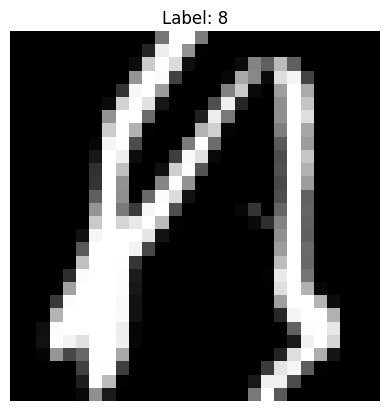

In [12]:
# TODO (Students need to fill this section)
# Select the first image and label
image = x_train[0]  # First image from the training set
label = y_train[0]  # First target label

# Plot the image
plt.imshow(image, cmap="gray")  # Display in grayscale
plt.title(f"Label: {label}")  # Show the label as title
plt.axis("off")  # Hide axes
plt.show()


# 4. Prepare Data

[4.1] **TODO** Reshape the images from the training and testing set to have the channel dimension last. The dimensions should be: (row_number, height, width, channel)

In [13]:
# TODO (Students need to fill this section)
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, 1)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, 1)

[4.2] **TODO** Cast `x_train` and `x_test` into `float32` decimals

In [14]:
# TODO (Students need to fill this section)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

[4.3] **TODO** Standardise the images of the training and testing sets. Originally each image contains pixels with value ranging from 0 to 255. after standardisation, the new value range should be from 0 to 1.

In [15]:
# TODO (Students need to fill this section)
x_train = x_train / 255.0
x_test = x_test / 255.0

[4.4] **TODO** Create a variable called `num_classes` that will take the value 10 which corresponds to the number of classes for the target variable

In [8]:
# TODO (Students need to fill this section)
num_classes = 10

[4.5] **TODO** Convert the target variable for the training and testing sets to a binary class matrix of dimension (rows, num_classes).

For example:
- class 0 will become [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- class 1 will become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
- class 5 will become [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
- class 9 will become [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [17]:
# TODO (Students need to fill this section)

# Function to convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels] #indexing the identity matrix of order num_classes*num_classes

# Convert the training and testing labels
y_train = one_hot_encode(y_train, num_classes)
y_test = one_hot_encode(y_test, num_classes)

# 5. Define Neural Networks Architecure

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[5.1] Set the seed in PyTorch for reproducing results



In [9]:
# TODO (Students need to fill this section)
seed = 25155591
torch.manual_seed(seed)       # Sets the seed for CPU operations
torch.cuda.manual_seed(seed)  # Sets the seed for CUDA (if using GPU)

[5.2] **TODO** Define the architecture of your Neural Networks and save it into a variable called `model`

In [18]:
# TODO (Students need to fill this section)
# Define the base model
class BaseModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(BaseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Fully connected layer 1
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # No softmax here because CrossEntropyLoss includes it
        return x

# Create the model
model = BaseModel()

[5.2] **TODO** Print the summary of your model

In [19]:
# TODO (Students need to fill this section)
print(model)

BaseModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 6. Train Neural Networks

[6.1] **TODO** Create 2 variables called `batch_size` and `epochs` that will  respectively take the values 128 and 500

In [10]:
# TODO (Students need to fill this section)
batch_size = 128
epochs = 500

[6.2] **TODO** Compile your model with the appropriate loss function, the optimiser of your choice and the accuracy metric

In [21]:
# TODO (Students need to fill this section)
# Define loss function
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Define optimizer
learning_rate = 0.001  # Typical starting value
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer

[6.3] **TODO** Train your model
using the number of epochs defined. Calculate the total loss and save it to a variable called total_loss.

In [24]:
total_loss = []  # Store loss per epoch
model.to(device)

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long).to(device)  # Convert to class indices

# Convert test data to PyTorch tensors
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long).to(device)  # Convert to class indices


In [25]:
# DataLoader to handle mini-batches
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [26]:
# Lists to store loss values
train_losses = []

In [27]:
# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0  # Reset loss for this epoch

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs.view(inputs.shape[0], -1))  # Flatten input
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        # Accumulate loss
        epoch_loss += loss.item()

    # Store loss for this epoch
    total_loss.append(epoch_loss / len(train_loader))
    train_losses.append(epoch_loss / len(train_loader))

    # Print loss every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss[-1]:.4f}")

print("Training complete.")

In [28]:
# Save both model and train_losses
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses
}, "trained_baseline_model.pth")
print("Model and train_losses saved successfully!")


In [30]:
# Load the checkpoint dictionary
#checkpoint = torch.load("trained_baseline_model.pth")

# Load the checkpoint dictionary on CPU
checkpoint = torch.load("trained_baseline_model.pth", map_location=torch.device('cpu')) #do this when GPU has run out


# Initialize the same model architecture
model = BaseModel()
model.load_state_dict(checkpoint['model_state_dict'])  # Load model parameters
model.eval()  # Set model to evaluation mode
model.to(device)
print("Model loaded successfully!")

# Restore the training losses
train_losses = checkpoint['train_losses']
print("train_losses loaded successfully!")


Model loaded successfully!
train_losses loaded successfully!


[6.4] **TODO** Test your model.  Initiate the model.eval() along with torch.no_grad() to turn off the gradients.


In [31]:
# Set model to evaluation mode
model.eval()

# Disable gradient calculation
correct = 0
total = 0


with torch.no_grad():
    outputs = model(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    correct = (predicted == y_test_tensor).sum().item()  # Count correct predictions
    total = y_test_tensor.size(0)

# Calculate accuracy
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 89.62%


# 7. Analyse Results

[7.1] **TODO** Display the performance of your model on the training and testing sets

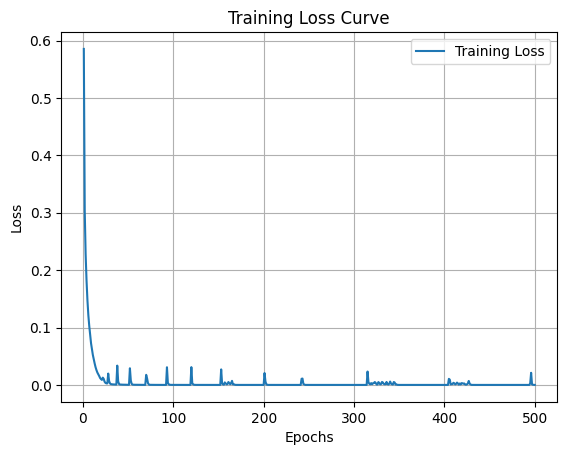

In [32]:
# TODO (Students need to fill this section)

# Plot training loss over epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()


[7.2] **TODO** Plot the learning curve of your model

In [33]:
# DataLoader to handle mini-batches
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [35]:
test_losses = []
model.eval()

for epoch in range(epochs):
    # Evaluation Phase (Test Loss)

    epoch_test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()

    # Compute average test loss for this epoch
    epoch_test_loss /= len(test_loader)
    test_losses.append(epoch_test_loss)

    # Print losses at intervals
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_losses[-1]:.4f}")

print("Testing loss evaluation complete.")


Epoch [50/500], Test Loss: 2.0997
Epoch [100/500], Test Loss: 2.0903
Epoch [150/500], Test Loss: 2.0566
Epoch [200/500], Test Loss: 2.0576
Epoch [250/500], Test Loss: 2.0566
Epoch [300/500], Test Loss: 2.0669
Epoch [350/500], Test Loss: 2.0769
Epoch [400/500], Test Loss: 2.0967
Epoch [450/500], Test Loss: 2.0619
Epoch [500/500], Test Loss: 2.0566
Testing loss evaluation complete.


In [36]:
print(train_losses)
print(len(train_losses))
print(test_losses)
print(len(test_losses))

[0.5854319358812466, 0.303192093904847, 0.22780147053476082, 0.18189133592505954, 0.14756195086723706, 0.121692621313941, 0.10279918366324292, 0.0867898818383466, 0.07241467494509622, 0.06224501792635363, 0.05214162623045096, 0.044437692238530245, 0.03734301367818293, 0.03082836245689025, 0.025772631228931232, 0.021569113163694517, 0.01863368878712945, 0.01554838240172452, 0.012107573483369626, 0.010128551986374294, 0.008767090862922704, 0.012656199025002115, 0.010522050517194195, 0.005559396539216063, 0.00341398981777129, 0.00267058726909485, 0.0025867111541565133, 0.019761494568872776, 0.006539318837654362, 0.00248777123607709, 0.0013845648591357992, 0.0011010203779655706, 0.0009449368057241822, 0.000875861747493185, 0.0007463727198637474, 0.0006846296037847637, 0.0006008558661621342, 0.03361258520124811, 0.006137842613515377, 0.0013987787545962469, 0.0007118948996300374, 0.0005676300261450906, 0.0004997137429585843, 0.0004383604836878307, 0.0003969798242533778, 0.0003544274376700821

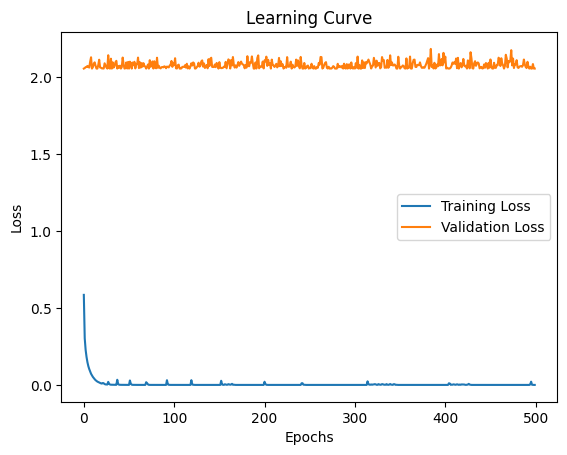

In [37]:
# Plot Learning Curve
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), test_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()


The above graph shows the loss in training and testing datasets over epochs. The training loss representation is valid, while the test loss is not. Since testing is done in a single go over the entire dataset in eval() mode, plotting test loss over epochs doesn't give any valid information. This highlights the need for a Validation dataset, which will be untouched during training and can be used for hyperparameter tuning alone.

[7.3] **TODO** Display the confusion matrix on the testing set predictions

In [ ]:
# TODO (Students need to fill this section)
# Set model to evaluation mode
model.eval()

# Disable gradient calculation
all_preds = []
all_labels = []

with torch.no_grad():
    outputs = model(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    all_preds.extend(predicted.cpu().numpy())  # Convert to NumPy & store
    all_labels.extend(y_test_tensor.cpu().numpy())  # Convert actual labels to NumPy

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print raw confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[927   3   2   0  18  12   2  19  15   2]
 [  3 889  19   0  15   4  38   5  13  14]
 [  8   9 858  46   9  14  19   8  19  10]
 [  5   4  25 937   1  10   9   0   6   3]
 [ 21  18   4  13 873  11  14  14  21  11]
 [  5   5  45   9  10 901  13   1   6   5]
 [  3  11  17   6  17   6 927   7   4   2]
 [  9   7  14   3  14   4  14 903  14  18]
 [ 11  19  19  24   6   8   7   1 902   3]
 [  3   9  19   6  18   3   7   4  14 917]]


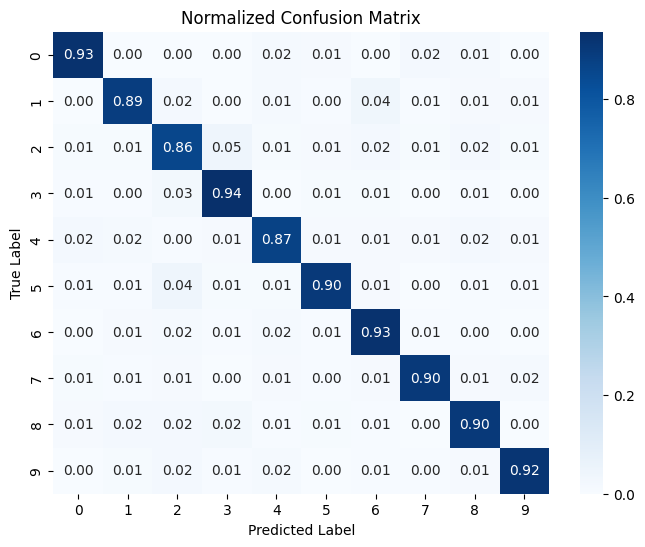

In [ ]:
# Define class labels (digits 0-9)
class_labels = [str(i) for i in range(10)]

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")

# Show the plot
plt.show()

#Experiment 2 (More Hidden Layers + Dropout)

In [57]:
class ExperimentModel2(nn.Module):
    def __init__(self, input_size=784, hidden_size1=256, hidden_size2=128, output_size=10, dropout_prob=0.3):
        super(ExperimentModel2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout after first layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout after second layer
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Create the model
model2 = ExperimentModel2()


In [58]:
print(model2)

ExperimentModel2(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


##Splitting the dataset into Train, Validation and Testing sets for better performance analysis

In [11]:
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

In [12]:
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, 1)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, 1)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = x_train / 255.0
x_test = x_test / 255.0

# Split training set into train (80%) and validation (20%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {x_train.shape[0]}")
print(f"Validation set size: {x_val.shape[0]}")
print(f"Test set size: {x_test.shape[0]}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000


In [15]:
# Convert train data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

# Convert validation data to PyTorch tensors
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Convert test data to PyTorch tensors
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# DataLoader to handle mini-batches
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader to handle mini-batches
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [61]:
# Define loss function
criterion = nn.CrossEntropyLoss()  # For multi-class classification

# Define optimizer
learning_rate = 0.001  # Typical starting value
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)  # Adam optimizer

In [63]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

# Training loop for model2
for epoch in range(epochs):
    model2.train()  # Set the model2 to training mode
    train_loss = 0.0

    # Training phase
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model2(inputs.view(inputs.shape[0], -1))  # Flatten input
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model2.eval()  # Set the model2 to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # No gradient computation needed for validation
        for inputs, labels in val_loader:
            outputs = model2(inputs.view(inputs.shape[0], -1))
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average losses for this epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print loss at specific epochs intervals
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Optionally, track the best model based on validation loss (for early stopping)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save model2 state_dict here if needed


Epoch [50/500], Train Loss: 0.0353, Validation Loss: 0.1869
Epoch [100/500], Train Loss: 0.0222, Validation Loss: 0.2112
Epoch [150/500], Train Loss: 0.0208, Validation Loss: 0.2471
Epoch [200/500], Train Loss: 0.0192, Validation Loss: 0.2657
Epoch [250/500], Train Loss: 0.0125, Validation Loss: 0.2626
Epoch [300/500], Train Loss: 0.0165, Validation Loss: 0.2724
Epoch [350/500], Train Loss: 0.0135, Validation Loss: 0.2927
Epoch [400/500], Train Loss: 0.0132, Validation Loss: 0.2981
Epoch [450/500], Train Loss: 0.0139, Validation Loss: 0.3061
Epoch [500/500], Train Loss: 0.0132, Validation Loss: 0.3026


In [70]:
# Save both model and train_losses
torch.save({
    'model_state_dict': model2.state_dict(),
    'train_losses': train_losses
}, "trained_exp2_model.pth")
print("Model and train_losses saved successfully!")

Model and train_losses saved successfully!


In [71]:
# Load the checkpoint dictionary
#checkpoint = torch.load("trained_baseline_model.pth")

# Load the checkpoint dictionary on CPU
checkpoint = torch.load("trained_exp2_model.pth", map_location=torch.device('cpu')) #do this when GPU has run out


# Initialize the same model architecture
model2 = ExperimentModel2()
model2.load_state_dict(checkpoint['model_state_dict'])  # Load model parameters
model2.eval()  # Set model to evaluation mode
model2.to(device)
print("Model loaded successfully!")

# Restore the training losses
train_losses = checkpoint['train_losses']
print("train_losses loaded successfully!")

Model loaded successfully!
train_losses loaded successfully!


In [72]:
# Set model to evaluation mode
model2.eval()

# Disable gradient calculation
correct = 0
total = 0


with torch.no_grad():
    outputs = model2(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    correct = (predicted == y_test_tensor).sum().item()  # Count correct predictions
    total = y_test_tensor.size(0)

# Calculate accuracy
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.42%


Model 2 is having a higher accuracy [90.42%] than our baseline model [89.62%].

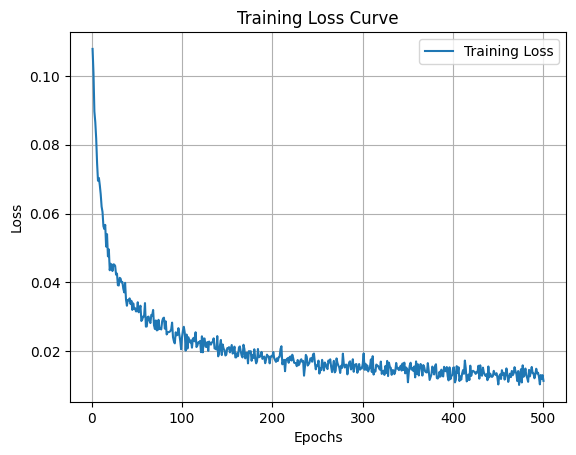

In [73]:
# Plot training loss over epochs
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()


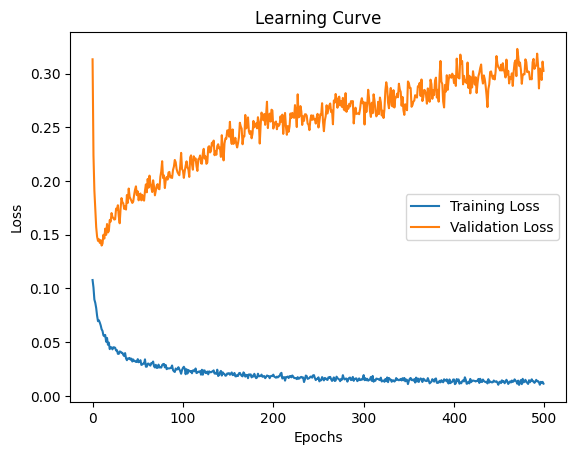

In [74]:
# Plot Learning Curve
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

Even though the model 2 is more accurate, it is overfitting, as seen from the learning curve above. The training loss keeps on decreasing, while the validation loss increases after an initial decrease. This suggests that the model is learning the noise or specific features of the training data that do not generalize well to unseen data.

In [75]:

# Set model to evaluation mode
model2.eval()

# Disable gradient calculation
all_preds = []
all_labels = []

with torch.no_grad():
    outputs = model2(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    all_preds.extend(predicted.cpu().numpy())  # Convert to NumPy & store
    all_labels.extend(y_test_tensor.cpu().numpy())  # Convert actual labels to NumPy

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print raw confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[900  11   3   1  19  20   0  27  16   3]
 [  4 894  16   3  18   4  37   3   9  12]
 [  8   7 855  59  12  13  15   9  13   9]
 [  3   4  19 958   2   4   5   1   2   2]
 [ 22  14   4  12 882   2  15   7  33   9]
 [  1   7  35   7   2 912  18   0  12   6]
 [  4   8  12   6  18   3 934   4   7   4]
 [  5  16   7   6  17   5  20 876  24  24]
 [  3  23  11  17   1   3   7   5 929   1]
 [ 12   9  11   6  20   3  15   6  16 902]]


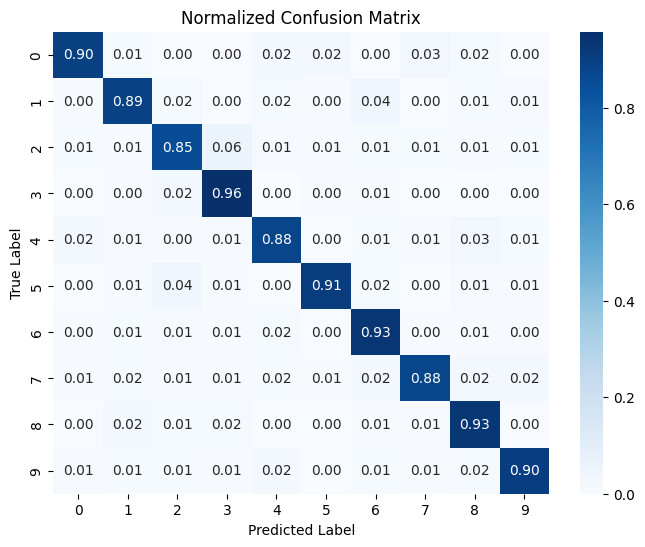

In [76]:
# Define class labels (digits 0-9)
class_labels = [str(i) for i in range(10)]

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")

# Show the plot
plt.show()

#Experiment 3

Features:-

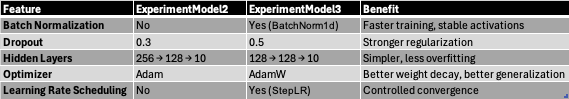



In [16]:
# Define the optimized model
class ExperimentModel3(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(ExperimentModel3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability
        self.batch_norm = nn.BatchNorm1d(hidden_size)  # Batch Normalization

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm(x)  # Batch normalization
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)  # Output layer (no activation since CrossEntropyLoss includes softmax)
        return x

# Initialize the model
model3 = ExperimentModel3()

In [82]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model3.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Learning rate scheduler to decay the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)


# Training loop with Learning Rate Scheduling
train_losses, val_losses = [], []
for epoch in range(epochs):
    model3.train()  # Set model to training mode
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs.view(inputs.shape[0], -1))  # Flatten the input
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model3.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model3(inputs.view(inputs.shape[0], -1))
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average losses for this epoch
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print the losses every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

# # Load the best model after training
# model3.load_state_dict(torch.load("best_model.pth"))
# model.eval()  # Set model to evaluation mode

# # Optional: plot train_losses and val_losses to monitor progress


Epoch [50/500], Train Loss: 0.1175, Validation Loss: 0.1398
Epoch [100/500], Train Loss: 0.0773, Validation Loss: 0.1582
Epoch [150/500], Train Loss: 0.0594, Validation Loss: 0.1714
Epoch [200/500], Train Loss: 0.0523, Validation Loss: 0.1776
Epoch [250/500], Train Loss: 0.0501, Validation Loss: 0.1806
Epoch [300/500], Train Loss: 0.0473, Validation Loss: 0.1839
Epoch [350/500], Train Loss: 0.0436, Validation Loss: 0.1824
Epoch [400/500], Train Loss: 0.0460, Validation Loss: 0.1833
Epoch [450/500], Train Loss: 0.0452, Validation Loss: 0.1835
Epoch [500/500], Train Loss: 0.0446, Validation Loss: 0.1858


In [83]:
# Save both model and train_losses
torch.save({
    'model_state_dict': model3.state_dict(),
    'train_losses': train_losses,
    'val_losses' : val_losses,
}, "trained_exp3_model.pth")
print("Model and losses saved successfully!")

Model and losses saved successfully!


In [17]:
# Load the checkpoint dictionary
#checkpoint = torch.load("trained_exp3_model.pth") #use when GPU is available

checkpoint = torch.load("trained_exp3_model.pth", map_location=torch.device('cpu')) #GPU ran out


# Initialize the same model architecture
model3 = ExperimentModel3()  # Ensure this matches your Experiment 3 model definition
model3.load_state_dict(checkpoint['model_state_dict'])  # Load model parameters
model3.eval()  # Set model to evaluation mode

# Restore the training and validation losses
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

print("Model and losses loaded successfully!")


Model and losses loaded successfully!


In [19]:
# Set model to evaluation mode
model3.eval()

# Disable gradient calculation
correct = 0
total = 0


with torch.no_grad():
    outputs = model3(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    correct = (predicted == y_test_tensor).sum().item()  # Count correct predictions
    total = y_test_tensor.size(0)

# Calculate accuracy
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 89.70%


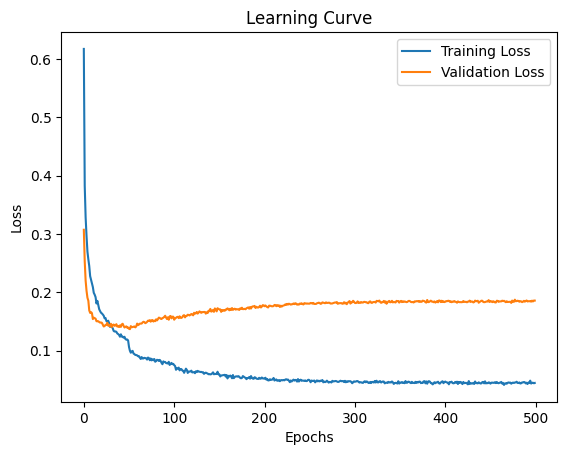

In [20]:
# Plot Learning Curve
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

From the above learning curve, we can see that Model 3 is performing significantly better than Model 2. Overall validation loss is lower, and there is no sharp increase, unlike model 2. It is relatively stable. The best (least) validation loss is at Epoch 50; thereafter, it increases slightly. So to have better genralisation ability and simplicity, we will reduce the number of epochs to 50.

Early stopping is not directly implemented in code- the new model is separately trained in the next part (50 epochs) for better readability and understanding.

In [21]:
# Reinitialize the model (from scratch, no previous weights)
model_fresh = ExperimentModel3()  # Ensure this matches the model3 architecture
model_fresh.to(device)  # Move to GPU if available

# Define loss function and optimizer again
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_fresh.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler (same as before)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

# Training loop for 50 epochs
fresh_train_losses = []
for epoch in range(50):  # Training for only 50 epochs
    model_fresh.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_fresh(inputs.view(inputs.shape[0], -1))  # Flatten input
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

print("Training from scratch for 50 epochs completed!")


Epoch [10/50], Train Loss: 81.4378
Epoch [20/50], Train Loss: 62.8785
Epoch [30/50], Train Loss: 45.9771
Epoch [40/50], Train Loss: 41.8244
Epoch [50/50], Train Loss: 39.2204
Training from scratch for 50 epochs completed!


In [27]:
# Set model to evaluation mode
model_fresh.eval()

# Disable gradient calculation
correct = 0
total = 0


with torch.no_grad():
    outputs = model_fresh(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    correct = (predicted == y_test_tensor).sum().item()  # Count correct predictions
    total = y_test_tensor.size(0)

# Calculate accuracy
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.05%


In [24]:
# Disable gradient calculation
all_preds = []
all_labels = []

with torch.no_grad():
    outputs = model_fresh(x_test_tensor.view(x_test_tensor.shape[0], -1))  # Flatten input
    _, predicted = torch.max(outputs, 1)  # Get predicted class indices

    all_preds.extend(predicted.cpu().numpy())  # Convert to NumPy & store
    all_labels.extend(y_test_tensor.cpu().numpy())  # Convert actual labels to NumPy

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print raw confusion matrix
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[914   1   1   0  19  15   4  22  20   4]
 [  6 886  17   0  16   6  38   0  15  16]
 [ 11  12 871  38   6  16  14   8  15   9]
 [  3   5  22 952   0   4   4   3   4   3]
 [ 39  20   7   7 852   5  17  12  30  11]
 [  3   8  40  13   7 897  15   1   9   7]
 [  5  10  18   5  11   2 940   5   3   1]
 [ 17  14  16   1  11   4  12 886  19  20]
 [  6  19   7  21   5   7  11   1 922   1]
 [  8   7  21  11  19   1  14  12  22 885]]


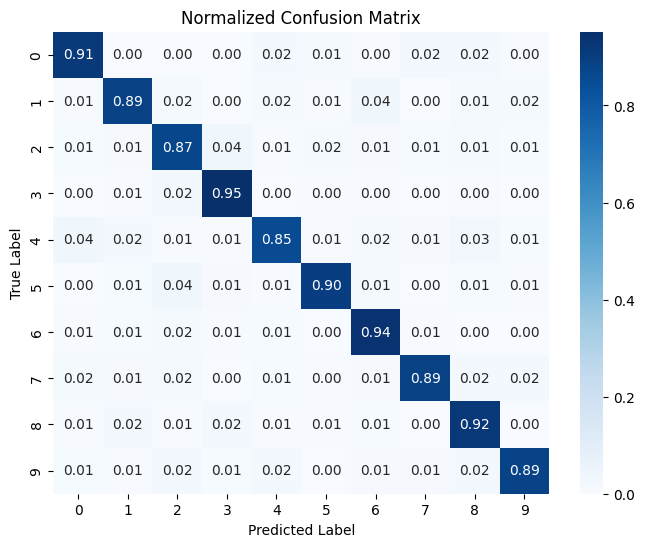

In [25]:
# Define class labels (digits 0-9)
class_labels = [str(i) for i in range(10)]

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")

# Show the plot
plt.show()